# Sectoral equity indicators

This notebook offers the necessary code to replicate the research findings discussed in the Macrosynergy research post "Sectoral equity factors". Its primary objective is to inspire readers to explore and conduct additional investigations whilst also providing a foundation for testing their own unique ideas.

On the back of our initial exploration of the [relationship between macroeconomic trends and sectoral equity indices](https://macrosynergy.com/research/macro-trends-and-equity-allocation-a-brief-introduction/), we explore a comprehensive set of ideas for capital allocation across sectors within the same country.

In order to prevent potential CPU and RAM issues the user might face while running the analysis, we have decided to split the content in two blocks. This notebook covers two main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis.

- Transformations and checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including building simple linear composite indicators.

You can find the rest of the analysis in the notebook "Sectoral equity factors". 

It is important to note that while the notebook covers a selection of indicators and strategies used for the post’s main findings, users can explore countless other possible indicators and approaches. Users can modify the code to test different hypotheses and strategies based on their research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
import copy
import warnings
import os
from tqdm import tqdm
from IPython.display import HTML

import numpy as np
import pandas as pd
from pandas import Timestamp

import matplotlib.pyplot as plt
import seaborn as sns

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv
from macrosynergy.download import JPMaQSDownload

warnings.simplefilter("ignore")

This notebook downloads selected indicators for the following cross-sections: AUD (Australian dollar), CAD (Canadian dollar), CHF (Swiss franc), EUR (euro), GBP (British pound),  HKD (Hong Kong dollar),  ILS (Israeli shekel), JPY (Japanese yen), NOK (Norwegian krone), NZD (New Zealand dollar), SEK (Swedish krona), SGD (Singapore dollar), USD (U.S. dollar) as well as five main European currencies  ['DEM', 'ESP', 'FRF', 'ITL', 'NLG'], replaced by EUR.

In [2]:
# Commodity cross sections
comm_cids = [
    "ALM", "CPR", "LED", "NIC", "TIN", "ZNC",  # non-precious metals
    "BRT", "WTI", "NGS", "GSO", "HOL",  # energy
    "CLB"  # lumber
]

# Equity sectoral cross-section lists: excluding HKD
cids_dmeq = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'ILS', 'JPY', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']
cids_eueq = ['DEM', 'ESP', 'FRF', 'ITL', 'NLG']
# to appropriately account for global growth dynamics even if we do not track the equity sectors
cids_extra = ['CNY', 'INR', 'IDR', 'MYR']

cids = sorted(cids_dmeq + cids_eueq + cids_extra)
cids_eqx = list(set(cids_dmeq) - {'HKD'})

In [3]:
sector_labels = {
    "ALL": "All sectors", 
    "COD": "Cons. discretionary",
    "COS": "Cons. staples",
    "CSR": "Communication services",
    "ENR": "Energy",
    "FIN": "Financials",
    "HLC": "Healthcare",
    "IND": "Industrials",
    "ITE": "Information tech",
    "MAT": "Materials",
    "REL": "Real estate",
    "UTL": "Utilities",
}
secx = list(sector_labels.keys())
secs = list(sector_labels.keys())[1:]

JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available either under [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected) or the [Macro Quantamental Academy](https://academy.macrosynergy.com/quantamental-indicators/). 

In particular, some of the indicators used in this notebook can be found in [Consumer price inflation trends](https://macrosynergy.com/academy/notebooks/consumer-price-inflation-trends), [Producer price inflation](https://macrosynergy.com/academy/notebooks/producer-price-inflation), [Manufacturing confidence](https://macrosynergy.com/academy/notebooks/manufacturing-confidence-scores), [Services confidence](https://macrosynergy.com/academy/notebooks/services-confidence-scores), [Private consumption](https://macrosynergy.com/academy/notebooks/private-consumption), [Foreign trade trends](https://macrosynergy.com/academy/notebooks/foreign-trade-trends), [Labor market dynamics](https://macrosynergy.com/academy/notebooks/labor-market-dynamics), [Technical GDP Growth](https://macrosynergy.com/academy/notebooks/technical-gdp-growth-estimates), and [Industrial production trends](https://macrosynergy.com/academy/notebooks/industrial-production-trends).

In [4]:
# Economic indicators
manuf = [
    # Manufacturing confidence scores
    "MBCSCORE_SA", "MBCSCORE_SA_D3M3ML3",
    # Industrial production trend
    "IP_SA_P1M1ML12_3MMA",
]
servi = [
    # Service confidence scores
    "SBCSCORE_SA", "SBCSCORE_SA_D3M3ML3", "SBCSCORE_SA_D1Q1QL1",
]
constr = [
    # construction confidence score
    "CBCSCORE_SA", "CBCSCORE_SA_D3M3ML3", "CBCSCORE_SA_D1Q1QL1",
    # construction trend
    "CSTR_SA_P1M1ML12_3MMA", "CSTR_SA_P1Q1QL4"
]
consu = [
    # Consumer confidence scores
    "CCSCORE_SA", "CCSCORE_SA_D3M3ML3", "CCSCORE_SA_D1Q1QL1",
    # private credit
    "PCREDITBN_SJA_P1M1ML12", 
    # retail sales
    "NRSALES_SA_P1M1ML12_3MMA", "RRSALES_SA_P1M1ML12_3MMA", "NRSALES_SA_P1Q1QL4", "RRSALES_SA_P1Q1QL4",
    # Real private consumption trend
    "RPCONS_SA_P1M1ML12_3MMA", "RPCONS_SA_P1Q1QL4",
]
cpi = [
    # Consumer core inflation: YoY, QoQ annualised
    "CPIH_SA_P1M1ML12",
    # Consumer core inflation: YoY, QoQ annualised
    "CPIC_SA_P1M1ML12",
    # Consumer inflation: food
    "CPIF_SA_P1M1ML12",
    # Consumer inflation: energy
    "CPIE_SA_P1M1ML12",
]
ppi = [
    # Producer Inflation: YoY, QoQ annualised
     "PPIH_NSA_P1M1ML12",
]
labour = [
    # Change in the labour force
    "WFORCE_NSA_P1Y1YL1", "WFORCE_NSA_P1Q1QL4",
    # Change in the employed workforce: GBP Empl in 3MMA
    "EMPL_NSA_P1Q1QL4", "EMPL_NSA_P1M1ML12_3MMA",
    # Change in unemployment
    "UNEMPLRATE_NSA_3MMA_D1M1ML12", "UNEMPLRATE_NSA_D1Q1QL4", 
    # Unemployment rate
    "UNEMPLRATE_SA_3MMAv5YMA",
    # Nominal wages trend
    "WAGES_NSA_P1M1ML12", "WAGES_NSA_P1Q1QL4",
]
exps = [
    # Export growth
    "EXPORTS_SA_P1M1ML12_3MMA", 
    # FX appreciation
    "REEROADJ_NSA_P1M12ML1", 
    # Commodity terms of trade - export and import price index
    "CTOT_NSA_P1M12ML1", "CXPI_NSA_P1M12ML1", "CMPI_NSA_P1M12ML1", 
    # Total external trade openness
    "EXALLOPENNESS_NSA_1YMA"
]

ecos = manuf + servi + consu + cpi + ppi + labour + exps + constr

# Complementary economic indicators
ecox = [
    "IVAWGT_SA_1YMA",
    "USDGDPWGT_SA_1YMA",
    "RGDP_SA_P1Q1QL4_20QMM",
    "INFTEFF_NSA",
    "INFTARGET_NSA",    
    "RGDPTECH_SA_P1M1ML12_3MMA",
    "INTLIQGDP_NSA_D1M1ML1", "INTLIQGDP_NSA_D1M1ML6",
    "GGDGDPRATIOX10_NSA",
    
    # Using Net as USD does not have most of the gross indicators
    "HHINTNETGDP_SA_D1M1ML12",
    "HHINTNETGDP_SA_D1Q1QL4",
    "HHINTNETGDP_SA_D1Y1YL1",    
    "CORPINTNETGDP_SA_D1Q1QL4",
    "CORPINTNETGDP_SA_D1Y1YL1",
    
    "RIR_NSA",    
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
]

# Market indicators
eqrets = ["EQC" + sec + ret for sec in secx for ret in ["R_NSA", "XR_NSA", "R_VT10"]]
fxrets = [
#     "FXXRUSD_NSA"
]
comm_xcats = [
    "COCRY_SAVT10", "COXR_VT10",  
    "XINVSCORECN_SA",  # for metal commodities
    "XINVSCOREUS_SA",  # mostly for energy commodities
    "XINVSCORELME_SA"  # for metal commodities
]

marks = eqrets + fxrets

# All indicators
xcats = ecos + ecox + marks

# Resultant tickers
comm_tickers = [cid + "_" + xcat for cid in comm_cids for xcat in comm_xcats]
bnchm_tickers = ["USD_EQXR_NSA", "USD_EQXR_VT10"]
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + comm_tickers + bnchm_tickers
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 2036


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).


In [5]:
client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(oauth=True, client_id=client_id, client_secret=client_secret) as dq:
    assert dq.check_connection()
    dfx = dq.download(
        tickers=tickers,
        start_date="1990-01-01",
        suppress_warning=True,
        metrics=["value"],
        show_progress=True,
    )
    assert isinstance(dfx, pd.DataFrame) and not dfx.empty

Timestamp UTC:  2024-11-19 11:06:56
Connection successful!


Requesting data: 100%|██████████| 102/102 [00:20<00:00,  4.89it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
622 out of 2036 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 9104 dates are missing.


In [6]:
dfx = dfx.sort_values(["cid", "xcat", "real_date"])

### Renaming and availability

Rename quarterly tickers to roughly equivalent monthly tickers to simplify subsequent operations.

In [7]:
dict_repl = {
    # labour
    "EMPL_NSA_P1Q1QL4": "EMPL_NSA_P1M1ML12_3MMA",
    "UNEMPLRATE_NSA_D1Q1QL4": "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "WAGES_NSA_P1Q1QL4": "WAGES_NSA_P1M1ML12",
    "WFORCE_NSA_P1Y1YL1": "WFORCE_NSA_P1Q1QL4",
    # private consumption
    "RPCONS_SA_P1Q1QL4": "RPCONS_SA_P1M1ML12_3MMA",
    "RRSALES_SA_P1Q1QL4": "RRSALES_SA_P1M1ML12_3MMA",
    "NRSALES_SA_P1Q1QL4": "NRSALES_SA_P1M1ML12_3MMA",
    # surveys
    "CCSCORE_SA_D1Q1QL1": "CCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA_D1Q1QL1": "SBCSCORE_SA_D3M3ML3",
    "CBCSCORE_SA_D1Q1QL1": "CBCSCORE_SA_D3M3ML3",
    # construction
    "CSTR_SA_P1Q1QL4": "CSTR_SA_P1M1ML12_3MMA",
    # debt servicing
    'CORPINTNETGDP_SA_D1Y1YL1': 'CORPINTNETGDP_SA_D1Q1QL4',
    'HHINTNETGDP_SA_D1Q1QL4': 'HHINTNETGDP_SA_D1M1ML12',
    'HHINTNETGDP_SA_D1Y1YL1': 'HHINTNETGDP_SA_D1M1ML12',
    'PRIVINTNETGDP_SA_D1Y1YL1': 'PRIVINTNETGDP_SA_D1Q1QL4',    
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

In [8]:
ecos_xq = list(set(ecos + ecox) - set(dict_repl.keys()))
msm.missing_in_df(dfx, xcats=ecos_xq, cids=cids_eqx)

No missing XCATs across DataFrame.
Missing cids for CBCSCORE_SA:                   ['AUD', 'GBP', 'NOK', 'NZD', 'SGD']
Missing cids for CBCSCORE_SA_D3M3ML3:           ['AUD', 'GBP', 'NOK', 'NZD', 'SGD']
Missing cids for CCSCORE_SA:                    ['SGD']
Missing cids for CCSCORE_SA_D3M3ML3:            ['SGD']
Missing cids for CMPI_NSA_P1M12ML1:             []
Missing cids for CORPINTNETGDP_SA_D1Q1QL4:      ['ILS', 'SEK', 'SGD']
Missing cids for CPIC_SA_P1M1ML12:              []
Missing cids for CPIE_SA_P1M1ML12:              ['NZD']
Missing cids for CPIF_SA_P1M1ML12:              ['NZD']
Missing cids for CPIH_SA_P1M1ML12:              []
Missing cids for CSTR_SA_P1M1ML12_3MMA:         ['JPY']
Missing cids for CTOT_NSA_P1M12ML1:             []
Missing cids for CXPI_NSA_P1M12ML1:             []
Missing cids for EMPL_NSA_P1M1ML12_3MMA:        []
Missing cids for EXALLOPENNESS_NSA_1YMA:        []
Missing cids for EXPORTS_SA_P1M1ML12_3MMA:      []
Missing cids for GGDGDPRATIOX10_NSA:   

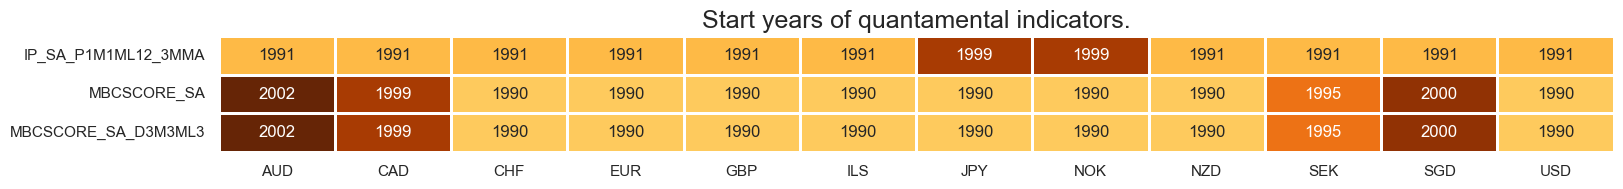

In [9]:
msm.check_availability(dfx, xcats=manuf, cids=cids_eqx, missing_recent=False)

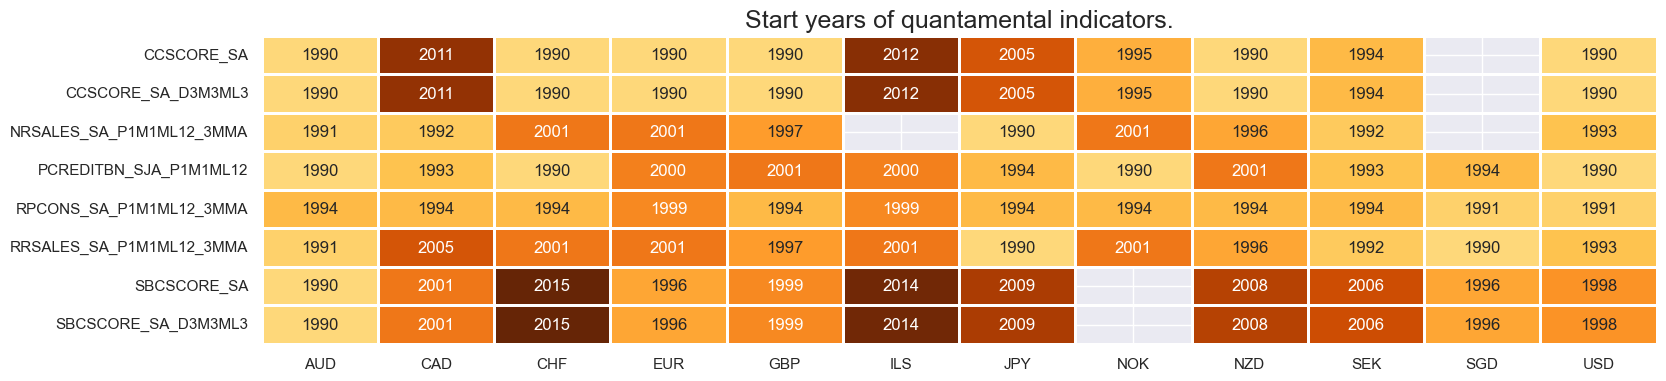

In [10]:
msm.check_availability(dfx, xcats=servi+consu, cids=cids_eqx, missing_recent=False)

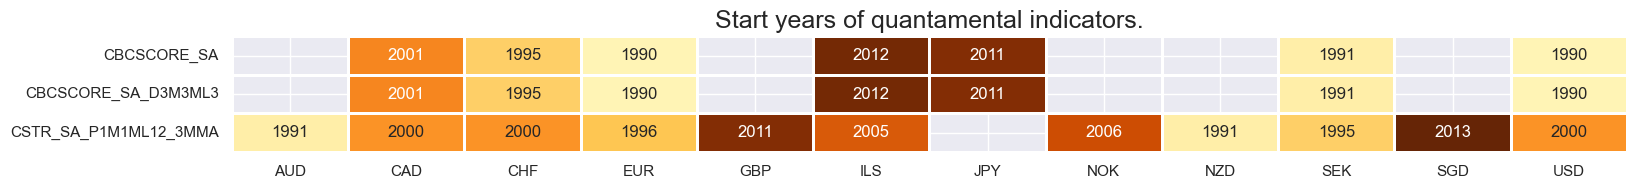

In [11]:
msm.check_availability(dfx, xcats=constr, cids=cids_eqx, missing_recent=False)

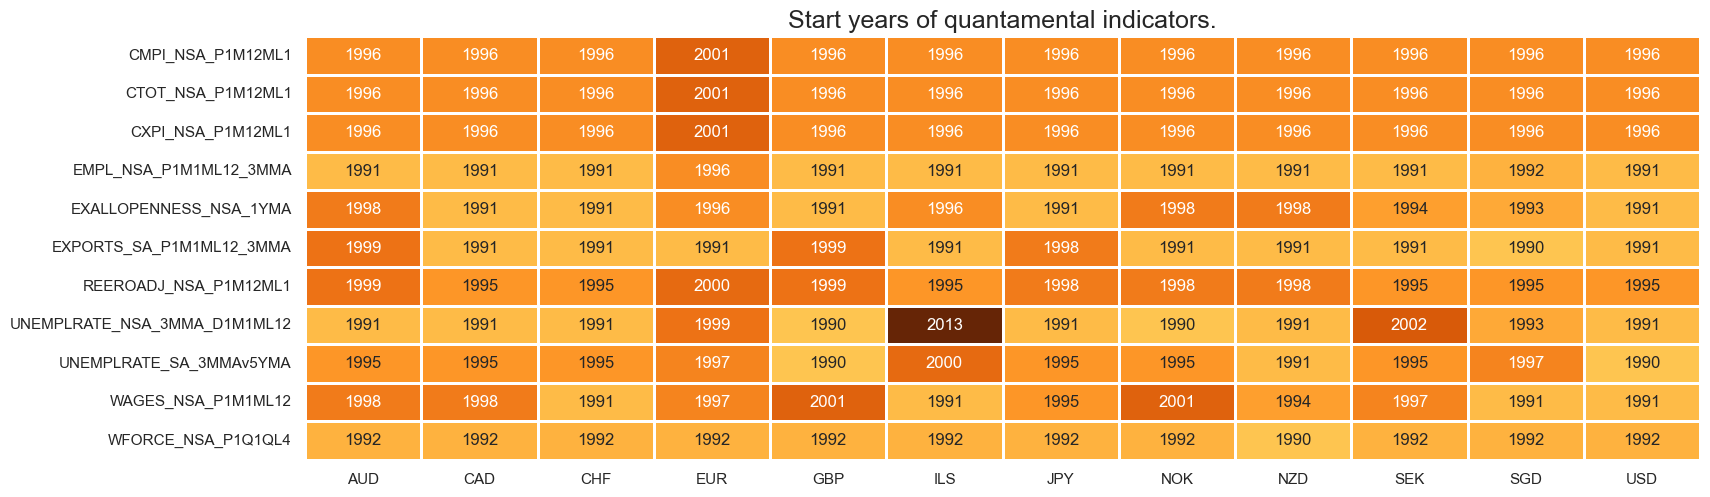

In [12]:
msm.check_availability(dfx, xcats=labour+exps, cids=cids_eqx, missing_recent=False)

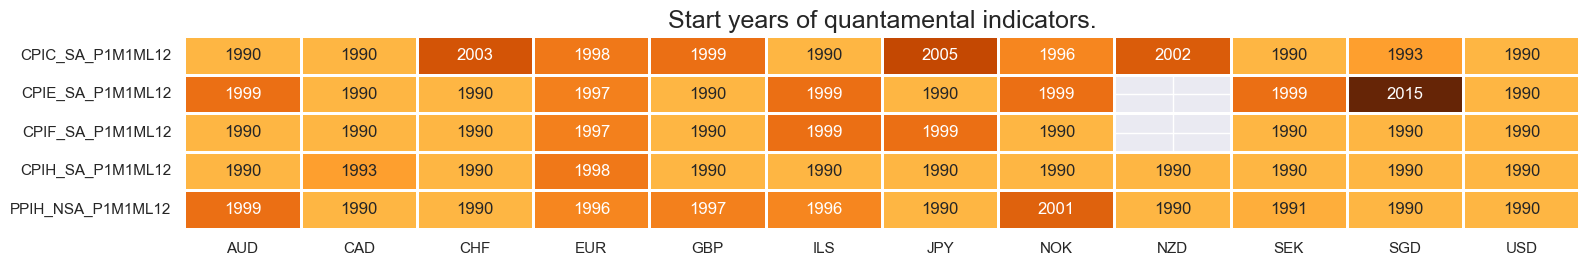

In [13]:
msm.check_availability(dfx, xcats=cpi+ppi, cids=cids_eqx, missing_recent=False)

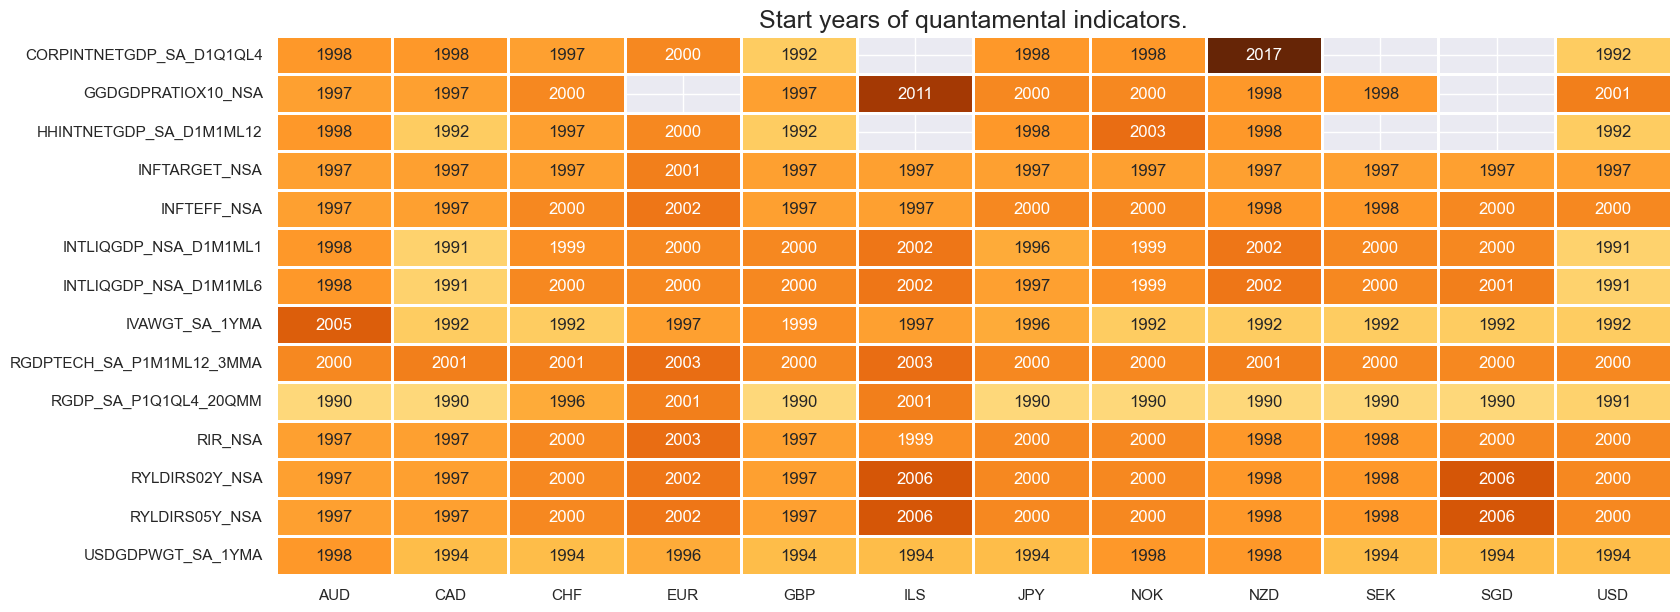

In [14]:
msm.check_availability(dfx, xcats=ecox, cids=cids_eqx, missing_recent=False)

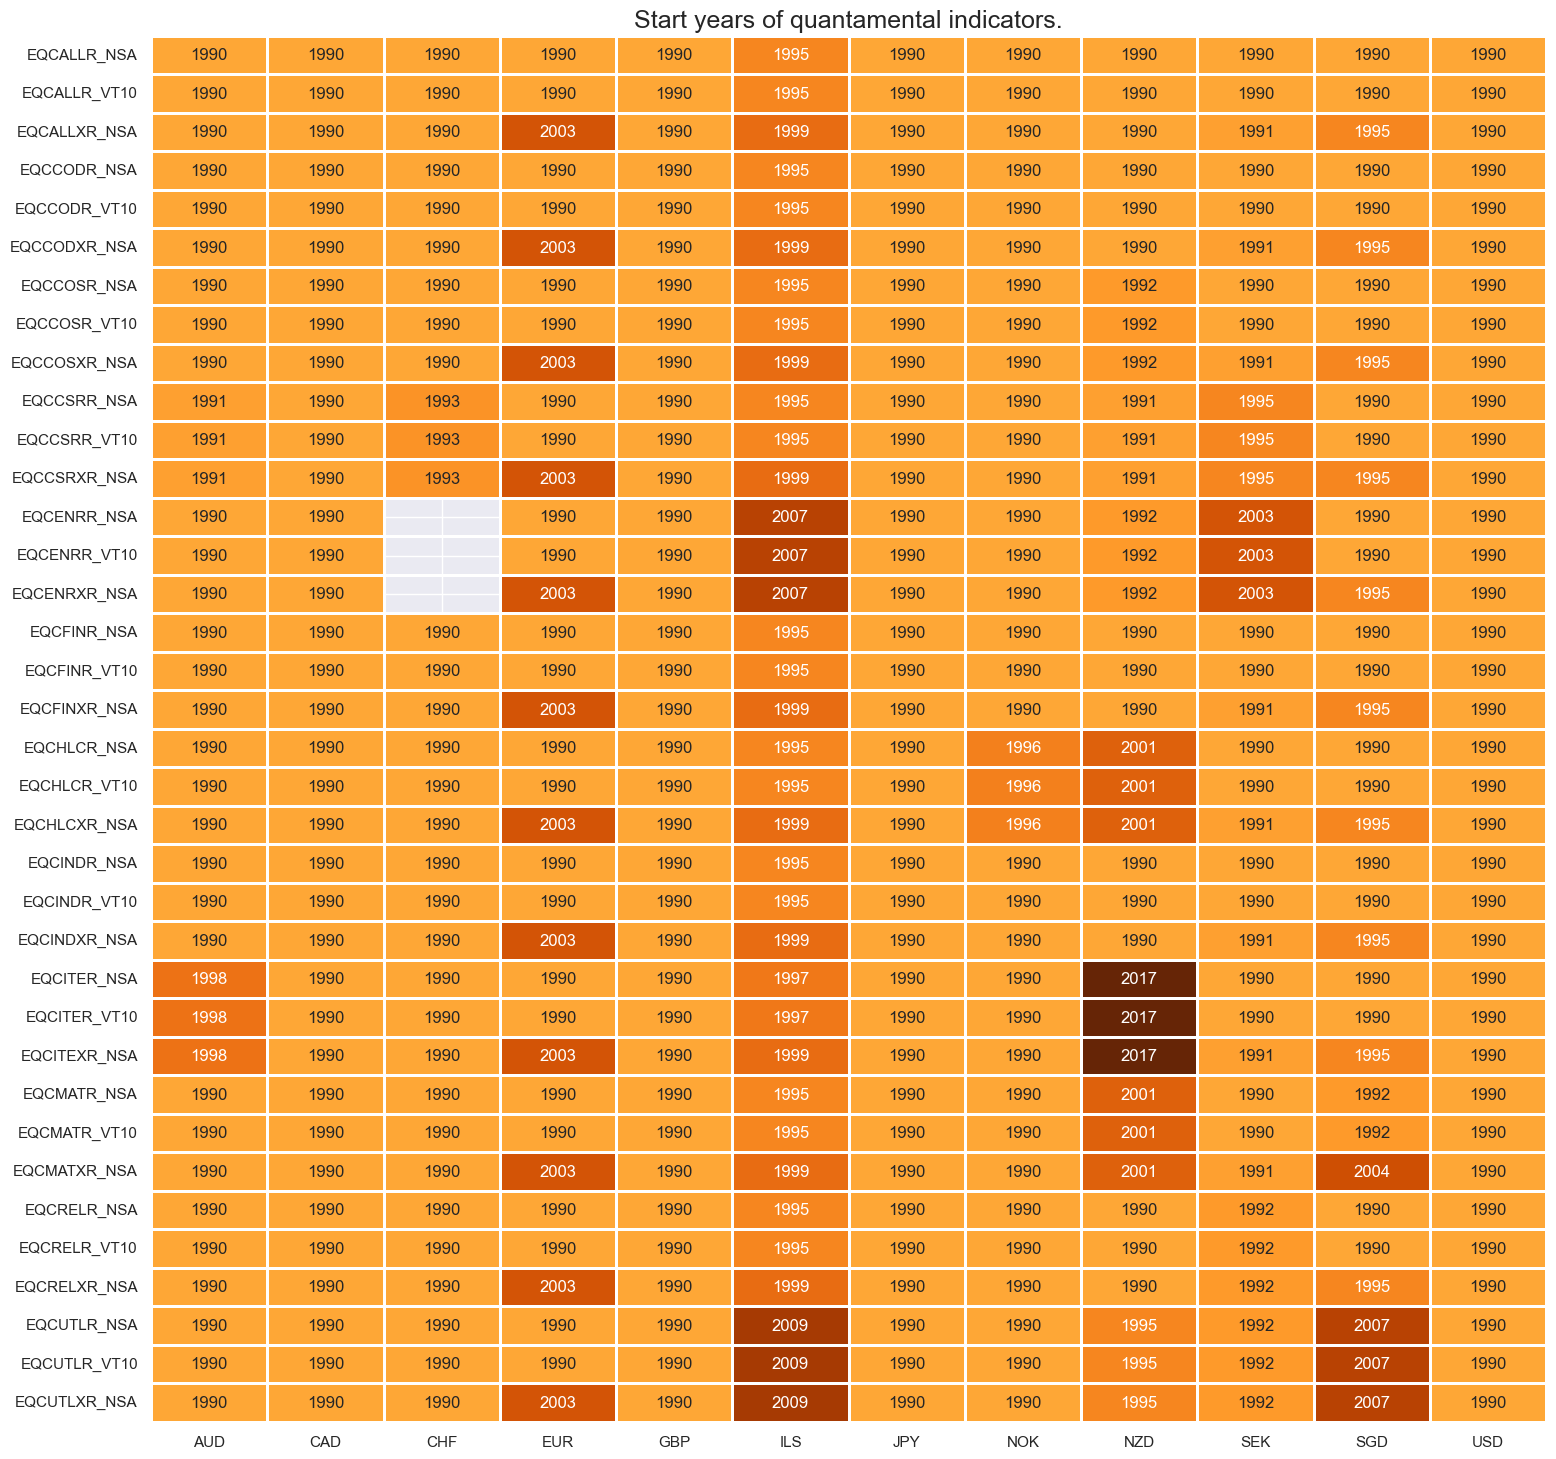

In [15]:
msm.check_availability(dfx, xcats=eqrets+fxrets, cids=cids_eqx, missing_recent=False)

## Transformations

### Excess inflation

In [16]:
calcs = [
    "XCPIC_SA_P1M1ML12 = CPIC_SA_P1M1ML12 - INFTEFF_NSA",
    "XCPIH_SA_P1M1ML12 = CPIH_SA_P1M1ML12 - INFTEFF_NSA",
    "XPPIH_NSA_P1M1ML12 = PPIH_NSA_P1M1ML12 - INFTEFF_NSA",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Excess food and energy CPI inflation

In [17]:
calcs = [
    "XCPIE_SA_P1M1ML12 = CPIE_SA_P1M1ML12 - INFTEFF_NSA",
    "XCPIF_SA_P1M1ML12 = CPIF_SA_P1M1ML12 - INFTEFF_NSA",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Excess retail sales and consumption

In [18]:
# Proxy nominal retail sales for countries where nominal sales not available

calcs = [
    "NRSALES_SA_P1M1ML12_3MMA = RRSALES_SA_P1M1ML12_3MMA + CPIH_SA_P1M1ML12",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=['ILS', 'SGD'])
dfx = msm.update_df(dfx, dfa)

In [19]:
calcs = [
    # Consumption: excess real private consumption
    "XRPCONS_SA_P1M1ML12_3MMA = RPCONS_SA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMM",
    # Excess sales
    "XNRSALES_SA_P1M1ML12_3MMA = NRSALES_SA_P1M1ML12_3MMA - ( RGDP_SA_P1Q1QL4_20QMM + INFTEFF_NSA )",
    "XRRSALES_SA_P1M1ML12_3MMA = RRSALES_SA_P1M1ML12_3MMA - ( RGDP_SA_P1Q1QL4_20QMM )",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Labour market dynamics

We also create an indicator for annual real wages growth, by subtracting the expected inflation target from the nominal wage change over a year ago.

In [20]:
calcs = [
    # Wages: adjustment for labour supply - excess real and nominal wages are going to be the same 
    "RWAGES_NSA_P1M1ML12 = WAGES_NSA_P1M1ML12 - INFTEFF_NSA",
    "XRWAGES_NSA_P1M1ML12 = RWAGES_NSA_P1M1ML12 - ( RGDP_SA_P1Q1QL4_20QMM - WFORCE_NSA_P1Q1QL4 )",
     # Excess employment growth
    "XEMPL_NSA_P1M1ML12_3MMA = EMPL_NSA_P1M1ML12_3MMA - WFORCE_NSA_P1Q1QL4",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Excess output growth

In [21]:
calcs = [
    # Technical GDP trend and industrial production are real measures
    "XRGDPTECH_SA_P1M1ML12_3MMA = RGDPTECH_SA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMM",
    "XIP_SA_P1M1ML12_3MMA = IP_SA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMM", 
    "XCSTR_SA_P1M1ML12_3MMA = CSTR_SA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMM"
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Excess foreign trade growth

In [22]:
calcs = [
    # Exports and imports are nominal measures
    "XEXPORTS_SA_P1M1ML12_3MMA = EXPORTS_SA_P1M1ML12_3MMA - RGDP_SA_P1Q1QL4_20QMM - INFTEFF_NSA",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Excess credit growth

In [23]:
calcs = [
    # Private credit creation is a nominal measure
    "XPCREDITBN_SJA_P1M1ML12 = PCREDITBN_SJA_P1M1ML12 - RGDP_SA_P1Q1QL4_20QMM - INFTEFF_NSA",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Interest rates dynamics

In [24]:
calcs = [
    # Yield curve slopes
    "RSLOPEMIDDLE_NSA = RYLDIRS05Y_NSA - RYLDIRS02Y_NSA",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Government spending and sustainability

In [25]:
# EUR does not have fiscal indicators so we approximate via equally-weighted indicators of 4 countries (NLG does not have it)
dfa = pd.DataFrame(columns=dfx.columns)
for xcat in ['GGDGDPRATIOX10_NSA']:
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xcat,
        cids=["DEM", "ESP", "FRF", "ITL"],
        weights=None, # "USDGDPWGT_SA_1YMA" missing for europeans
        new_cid="EUR",
        complete_cids=False,
        complete_xcats=False,
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

In [26]:
calcs = [
    # Normalising the projected debt levels around 100 for better z-scores
    "XGGDGDPRATIOX10_NSA = GGDGDPRATIOX10_NSA - 100",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids)
dfx = msm.update_df(dfx, dfa)

### Commodity carry (seasonally adjusted)

In [27]:
def assign_commodity_indicators(input_df: pd.DataFrame, assignee_cids: list) -> pd.DataFrame:
    
    assert len(input_df["cid"].unique()) == 1, "Multiple commodity cids are provided, this is not expected: reduce to 1." 
    assert len(input_df["xcat"].unique()) == 1, "Multiple commodity xcats are provided, this is not expected: reduce to 1."
    
    out_df = pd.concat([
        input_df.drop(columns=['cid']).assign(cid=new_cid) for new_cid in assignee_cids
    ], axis=0, ignore_index=True)
    
    return out_df

In [28]:
# Contruction materials carry
xcatx = "COCRY_SAVT10"
cidx = ["ALM", "CPR", "LED", "NIC", "TIN", "ZNC", "CLB"]
sdate = "1990-01-01"

dfa = msp.linear_composite(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    complete_xcats=False,
    start=sdate,
    new_cid="GLB",
)
dfa["xcat"] = "BMLCOCRY_SAVT10"

# Rolling average to smooth out the impact of single outliers when rebalancing
calcs = [
    "BMLCOCRY_SAVT10_21DMA = BMLCOCRY_SAVT10.rolling(21).mean()",
]
dfa = msp.panel_calculator(dfa, calcs, cids=["GLB"])

# We assign it to each CID in the sample
dfxx = assign_commodity_indicators(input_df=dfa, assignee_cids=cids_eqx)
dfx = msm.update_df(dfx, dfxx)

### Commodity return diffences

In [29]:
# Short term trend for the spread between refined products and crude oil (WTI)
cidx = ["GSO", "HOL"]
sdate = "1990-01-01"

# for each of the refined products we compute the variation of the spread vs base crude oil (WTI as both traded in the USA)
calcs = [
    "COXR_VT10vWTI_21DMA = ( COXR_VT10 - iWTI_COXR_VT10 ).rolling(21).mean()",
]
dfa = msp.panel_calculator(dfx, calcs, cids=cidx)

# We average these and 
dfa = msp.linear_composite(
    df=dfa,
    xcats=["COXR_VT10vWTI_21DMA"],
    cids=cidx,
    complete_xcats=False,
    start=sdate,
    new_cid="GLB",
)

# We assign it to each CID in the sample
dfxx = assign_commodity_indicators(input_df=dfa, assignee_cids=cids_eqx)
dfx = msm.update_df(dfx, dfxx)

### Commodity inventory scores

In [30]:
# Global commodities inventories: Brent, Tin, and Lumber are excluded
cidx = ["ALM", "CPR", "LED", "NIC", "ZNC", "WTI", "NGS", "GSO", "HOL"]
xcatx = ["XINVSCORECN_SA", "XINVSCOREUS_SA", "XINVSCORELME_SA"]
sdate = "1990-01-01"

dfa = pd.DataFrame(columns=dfx.columns)
for cid in cidx:
    dfaa = msp.linear_composite(
        df=dfx,
        xcats=xcatx,
        cids=cid,
        complete_xcats=False,
        start=sdate,
        new_xcat="XINVSCORE_SA"
    )
    dfa = msm.update_df(dfa, dfaa)

# Grouping different set of commodities under a single indicator and projecting it to all the geographical cids
inv_groups = {
    'BMLXINVCSCORE_SA': ["ALM", "CPR", "LED", "NIC", "ZNC",],
    'REFIXINVCSCORE_SA': ["GSO", "HOL"],
    'BASEXINVCSCORE_SA': ["WTI", "NGS",]
}

for new_xcat, target_cids in inv_groups.items():
    dfxx = msp.linear_composite(
        df=dfa,
        xcats="XINVSCORE_SA",
        cids=target_cids,
        complete_xcats=False,
        start=sdate,
        new_cid='GLB'
    )
    dfxx["xcat"] = new_xcat
    # We assign it to each CID in the sample
    dfxx = assign_commodity_indicators(input_df=dfxx, assignee_cids=cids_eqx)
    dfx = msm.update_df(dfx, dfxx)

### Openess-adjustment

The relevance of the country's economic trends sometimes goes beyond the country's border. To account for this global effect, we are building a set of indicators incorporating both local and global dynamics, adjusting by the individual country's sensitivity to foreign economic trends.

The first set of categories will be aggregated to a global score using the industrial value added weights, as they are more closely related to the supply side. Others will instead be paired with USD-denominated GDP shares, as it more comprehensively reflects the economic trends.

In [31]:
def create_trade_adjusted_indicators(df_input: pd.DataFrame, cids: list, target_xcats: list, glb_weight_xcat: str, trade_weight_xcat: str):
    """
    
    """
    assert isinstance(cids, list)
    assert isinstance(target_xcats, list)
    assert isinstance(glb_weight_xcat, str)
    assert isinstance(trade_weight_xcat, str)
    
    # starting data
    dfa = df_input.loc[
        (
            df_input["xcat"].isin(target_xcats + [glb_weight_xcat] + [trade_weight_xcat])
        ) & (
            df_input["cid"].isin(cids)
        )
    ].copy()
    # computing the global weighted average for each of the indicators
    for xc in tqdm(target_xcats):
        dfaa = msp.linear_composite(
            df=df_input,
            xcats=xc,
            cids=cids,
            weights=glb_weight_xcat,
            new_cid="GLB",
            complete_cids=False,
            complete_xcats=False,
        )
        dfa = msm.update_df(dfa, dfaa)
        
    # computing a sum of the wights to be used in the rescaling
    dfaa = msp.linear_composite(
        df=df_input,
        xcats=[glb_weight_xcat],
        cids=cids,
        new_cid="GLB",
        complete_cids=False,
        complete_xcats=False,
    )
    dfa = msm.update_df(dfa, dfaa)
    
    # Splitting the weighted average in 3 components
    # 1) Local component
    # 2) Global component ex local one
    # 3) Adjustment factor for the global component weight reflecting the appropriate contribution of the other countries
    calcs = [
        f"{xcat}_WG = ( {xcat} * ( 1 - {trade_weight_xcat} / 2 ) ) + ( {trade_weight_xcat} / 2) * ( iGLB_{glb_weight_xcat} / ( iGLB_{glb_weight_xcat} - {glb_weight_xcat} ) ) * ( iGLB_{xcat} - ( {glb_weight_xcat} * {xcat} ) )"
        for xcat in target_xcats
    ]
    df_output = msp.panel_calculator(dfa, calcs, cids=cids)
        
    return df_output

In [32]:
xcatx = [
    "CBCSCORE_SA",
    "CBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA",
    "MBCSCORE_SA_D3M3ML3",
    "XIP_SA_P1M1ML12_3MMA",
    "XCSTR_SA_P1M1ML12_3MMA"
]
# using all CIDs, including the countries outside the sectoral equity scope
globaladj_cids = list(set(cids) - set(cids_eueq))

ivaadj_df = create_trade_adjusted_indicators(
    df_input=dfx, 
    cids=globaladj_cids, 
    target_xcats=xcatx, 
    glb_weight_xcat='IVAWGT_SA_1YMA', 
    trade_weight_xcat='EXALLOPENNESS_NSA_1YMA'
)

dfx = msm.update_df(dfx, ivaadj_df)

100%|██████████| 6/6 [00:19<00:00,  3.27s/it]


In [33]:
xcatx = [
    "CCSCORE_SA",
    "CCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA",
    "SBCSCORE_SA_D3M3ML3",
    "XCPIF_SA_P1M1ML12",
    "XCPIE_SA_P1M1ML12",
    "XRPCONS_SA_P1M1ML12_3MMA",
    "XPCREDITBN_SJA_P1M1ML12",
    "XNRSALES_SA_P1M1ML12_3MMA",
    "XRRSALES_SA_P1M1ML12_3MMA",
    "XRGDPTECH_SA_P1M1ML12_3MMA",
    "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "UNEMPLRATE_SA_3MMAv5YMA",
    "XEMPL_NSA_P1M1ML12_3MMA",
    "HHINTNETGDP_SA_D1M1ML12",
    "CORPINTNETGDP_SA_D1Q1QL4",
    "XGGDGDPRATIOX10_NSA",
]
# using all CIDs, including the countries outside the sectoral equity scope
globaladj_cids = list(set(cids) - set(cids_eueq))

gdpadj_df = create_trade_adjusted_indicators(
    df_input=dfx, 
    cids=globaladj_cids, 
    target_xcats=xcatx, 
    glb_weight_xcat='USDGDPWGT_SA_1YMA', 
    trade_weight_xcat='EXALLOPENNESS_NSA_1YMA'
)

dfx = msm.update_df(dfx, gdpadj_df)

100%|██████████| 17/17 [01:04<00:00,  3.82s/it]


### Normalised quantamental indicators

In [34]:
orig_xcats = [
    # Surveys: local values
    "CBCSCORE_SA",
    "CBCSCORE_SA_D3M3ML3",
    "CCSCORE_SA",
    "CCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA",
    "MBCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA",
    "SBCSCORE_SA_D3M3ML3",
    
    # Surveys: weighted global values 
    "CBCSCORE_SA_WG",
    "CBCSCORE_SA_D3M3ML3_WG",
    "CCSCORE_SA_WG",
    "CCSCORE_SA_D3M3ML3_WG",
    "MBCSCORE_SA_WG",
    "MBCSCORE_SA_D3M3ML3_WG",
    "SBCSCORE_SA_WG",
    "SBCSCORE_SA_D3M3ML3_WG",
    
    # Inflation: local values
    "XCPIC_SA_P1M1ML12",
    "XCPIH_SA_P1M1ML12",
    "XCPIE_SA_P1M1ML12",
    "XCPIF_SA_P1M1ML12",
    "XPPIH_NSA_P1M1ML12",
 
    # Inflation: weighted global values
    "XCPIE_SA_P1M1ML12_WG",
    "XCPIF_SA_P1M1ML12_WG",
    
    # Domestic activity: local values
    "XRGDPTECH_SA_P1M1ML12_3MMA",
    "XCSTR_SA_P1M1ML12_3MMA",
    "XIP_SA_P1M1ML12_3MMA",
    "XPCREDITBN_SJA_P1M1ML12",
    "XNRSALES_SA_P1M1ML12_3MMA",
    "XRRSALES_SA_P1M1ML12_3MMA",
    "XRPCONS_SA_P1M1ML12_3MMA",
    
    # Domestic activity: weighted global values
    "XRGDPTECH_SA_P1M1ML12_3MMA_WG",
    "XCSTR_SA_P1M1ML12_3MMA_WG",
    "XIP_SA_P1M1ML12_3MMA_WG",
    "XPCREDITBN_SJA_P1M1ML12_WG",
    "XNRSALES_SA_P1M1ML12_3MMA_WG",
    "XRRSALES_SA_P1M1ML12_3MMA_WG",
    "XRPCONS_SA_P1M1ML12_3MMA_WG",
    
    # Labor market: local values
    "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "UNEMPLRATE_SA_3MMAv5YMA",
    "WFORCE_NSA_P1Q1QL4",
    "XEMPL_NSA_P1M1ML12_3MMA",
    "XRWAGES_NSA_P1M1ML12",
    
    # Labor market: weighted global values
    "UNEMPLRATE_NSA_3MMA_D1M1ML12_WG",
    "UNEMPLRATE_SA_3MMAv5YMA_WG",
    "XEMPL_NSA_P1M1ML12_3MMA_WG",
    
    # Trade and competitiveness
    "XEXPORTS_SA_P1M1ML12_3MMA",
    "CXPI_NSA_P1M12ML1",
    "CMPI_NSA_P1M12ML1",
    "CTOT_NSA_P1M12ML1",
    "REEROADJ_NSA_P1M12ML1",

    # Financial conditions: local values
    "INTLIQGDP_NSA_D1M1ML1",
    "INTLIQGDP_NSA_D1M1ML6",
    "XGGDGDPRATIOX10_NSA",
    "HHINTNETGDP_SA_D1M1ML12",    
    "CORPINTNETGDP_SA_D1Q1QL4",
    
    # Financial conditions: weighted global values
    "HHINTNETGDP_SA_D1M1ML12_WG",
    "CORPINTNETGDP_SA_D1Q1QL4_WG",
    "XGGDGDPRATIOX10_NSA_WG",
    
    # Financial markets
    "RIR_NSA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "RSLOPEMIDDLE_NSA",
    "BMLCOCRY_SAVT10_21DMA",
    "BMLXINVCSCORE_SA", 
    "REFIXINVCSCORE_SA", 
    "BASEXINVCSCORE_SA",
    "COXR_VT10vWTI_21DMA"
]

In [35]:
xcatx = orig_xcats 
cidx = cids_eqx
zscore_threshold = 2

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in tqdm(xcatx):
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 3,
        neutral="zero",
        pan_weight=1,
        thresh=zscore_threshold,
        postfix="_ZN",
        est_freq="q",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

scored_xcats = [s + "_ZN" for s in orig_xcats]

100%|██████████| 67/67 [03:45<00:00,  3.37s/it]


### Support quantamental indicators

For convenience, we add the version of the indicators with inverted sign, so that we can look at the hypotheses tested without worrying about the directional impact.

This will also help us in the subsequent learning process, as we can constrain the sign of the coefficients to be positive.

In [36]:
reverse_xcats = [cat+"_NEG" for cat in scored_xcats]

# Panel calculator is inefficient
dfa = dfx.copy()
dfa["value"] = dfa["value"] * -1
dfa["xcat"] = dfa["xcat"] + "_NEG"
dfx = msm.update_df(dfx, dfa)

### Targets: relative sectoral returns

In addition to the standard sectoral equity returns, we build new return series to be able to analyse the country's sectoral performance in excess of the local equity market.

We compute the sector-specific return `vALL` in a given region by subtracting from each indicator the equal-weighted average of sector returns of the corresponding cross-section. To do this, we apply the Macrosynergy package method `make_relative_category()` from the `macrosynergy` package.

An alternative option would be subtracting the aggregate equity index return `EQCALLR_NSA` from each of the sectoral returns.

In [37]:
cidx = cids_eqx
dfa = pd.DataFrame(columns=dfx.columns)

for ret in ["R_NSA", "R_VT10"]:
    xcatx = [f"EQC{sec}{ret}" for sec in secs]
    dfaa = msp.make_relative_category(
        df=dfx,
        xcats=xcatx,
        cids=cidx,
        start="1990-01-01",
        basket=None,
        complete_set=False,
        rel_meth="subtract",
        postfix="vALL",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)

The cross section, CHF, is missing ['EQCENRR_NSA'] from the requested basket. The new basket will be ['EQCCODR_NSA', 'EQCCOSR_NSA', 'EQCCSRR_NSA', 'EQCFINR_NSA', 'EQCHLCR_NSA', 'EQCINDR_NSA', 'EQCITER_NSA', 'EQCMATR_NSA', 'EQCRELR_NSA', 'EQCUTLR_NSA'].
The cross section, CHF, is missing ['EQCENRR_VT10'] from the requested basket. The new basket will be ['EQCCODR_VT10', 'EQCCOSR_VT10', 'EQCCSRR_VT10', 'EQCFINR_VT10', 'EQCHLCR_VT10', 'EQCINDR_VT10', 'EQCITER_VT10', 'EQCMATR_VT10', 'EQCRELR_VT10', 'EQCUTLR_VT10'].


## Local data copy

We save the data locally so that we can continue the analysis later in the second notebook.

In [38]:
focus_xcats = scored_xcats + reverse_xcats
focus_returns = [
    f"EQC{sec}R_NSAvALL" for sec in secs
] + [
    f"EQC{sec}R_VT10vALL" for sec in secs
] + [
    f"EQC{sec}XR_NSA" for sec in secs
] + [
    "XR_NSA", "XR_VT10"
]

dfxx = dfx.loc[
    (dfx["cid"].isin(cids_eqx))
    &
    (dfx["xcat"].isin(focus_xcats + focus_returns))
]

In [39]:
# Change path according to your own file system
OUTPUT_PATH = os.path.join(os.getcwd(), "..\..\..\..\equity_sectoral_notebook_data.csv")

dfxx.to_csv(OUTPUT_PATH)